In [1]:
# Imports
import os

import torch
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, random_split

from AnimationDataset import AnimationDataset
from constants import TRAIN_DATASET_SAMPLES_DIR, TRAIN_DATASET_INFO_CSV_FILE, TEST_DATASET_SAMPLES_DIR, \
    TEST_DATASET_INFO_CSV_FILE, Z_DIM, NUM_DIMS, SAMPLE_LENGTH
from cvae import CVAE

In [2]:
# Local constants
NUM_EPOCHS = 100
MAX_TEST_SAMPLES_TO_VIEW = 4
figures_dir = "figures"
os.makedirs(figures_dir, exist_ok=True)

In [3]:
# Use for tracking
train_losses = []
test_losses = []
test_samples = []

In [4]:
# Load dataset
train_dataset = AnimationDataset(TRAIN_DATASET_INFO_CSV_FILE, sample_dir=TRAIN_DATASET_SAMPLES_DIR, transform=None)
test_dataset = AnimationDataset(TEST_DATASET_INFO_CSV_FILE, sample_dir=TEST_DATASET_SAMPLES_DIR, transform=None)

In [5]:
# Determine train-validation split
train_size = int(0.8 * len(train_dataset))
validation_size = len(train_dataset) - train_size

In [6]:
# Load separate train and validation datasets
train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])
animation_shape = train_dataset[0]["animation"].shape
human_input_shape = train_dataset[0]["human_input"].shape
print(f"Animation shape: {animation_shape}")
print(f"Human input shape: {human_input_shape}")

Animation shape: torch.Size([150, 2])
Human input shape: torch.Size([150, 2])


In [7]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=4, shuffle=False, num_workers=0)

In [8]:
# Create new model
cvae = CVAE(x_shape=animation_shape, h_dim1=128, h_dim2=64, z_dim=Z_DIM, c_shape=human_input_shape)

In [9]:
# Move the model to cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cvae = cvae.to(device)

In [10]:
# Define the optimizer
optimizer = optim.Adam(cvae.parameters())

In [11]:
# Compute reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    recon_x = recon_x.view(recon_x.size(0), -1)
    x = x.view(x.size(0), -1)
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return MSE + KLD

In [12]:
# Train model
def train(epoch):
    cvae.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        times, animation, human_input = data["times"], data["animation"], data["human_input"]

        animation, human_input = animation.to(device), human_input.to(device)

        optimizer.zero_grad()

        recon_batch, mu, log_var = cvae(animation, human_input)
        loss = loss_function(recon_batch, animation, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item() / len(animation)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    train_losses.append(round(train_loss / len(train_loader.dataset), 4))

In [13]:
# Evaluate model performance
def evaluate(epoch):
    cvae.eval()
    test_loss = 0
    with torch.no_grad():
        for data in validation_loader:
            times, animation, human_input = data["times"], data["animation"], data["human_input"]

            animation, human_input = animation.to(device), human_input.to(device)

            recon, mu, log_var = cvae(animation, human_input)

            if epoch == NUM_EPOCHS and len(test_samples) < MAX_TEST_SAMPLES_TO_VIEW:
                test_samples.append(
                    {"times": times[0], "original_animation": animation[0], "human_input": human_input[0],
                     "reconstructed_animation": recon[0]})

            # sum up batch loss
            test_loss += loss_function(recon, animation, mu, log_var).item()

    test_loss /= len(validation_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    test_losses.append(round(test_loss, 4))

In [14]:
# Train and evaluate
for epoch in range(1, NUM_EPOCHS + 1):
    train(epoch)
    evaluate(epoch)

Train Epoch: 1 	Loss: 36.283119
====> Epoch: 1 Average loss: 31.4245
====> Test set loss: 25.9393
Train Epoch: 2 	Loss: 32.628159
====> Epoch: 2 Average loss: 21.3757
====> Test set loss: 21.1935
Train Epoch: 3 	Loss: 15.389183
====> Epoch: 3 Average loss: 15.4363
====> Test set loss: 14.1476
Train Epoch: 4 	Loss: 8.853461
====> Epoch: 4 Average loss: 9.8884
====> Test set loss: 8.6447
Train Epoch: 5 	Loss: 4.866128
====> Epoch: 5 Average loss: 6.2665
====> Test set loss: 5.6489
Train Epoch: 6 	Loss: 3.600094
====> Epoch: 6 Average loss: 3.5574
====> Test set loss: 2.7046
Train Epoch: 7 	Loss: 2.120795
====> Epoch: 7 Average loss: 1.9992
====> Test set loss: 1.3614
Train Epoch: 8 	Loss: 1.325612
====> Epoch: 8 Average loss: 1.0929
====> Test set loss: 0.8666
Train Epoch: 9 	Loss: 0.815783
====> Epoch: 9 Average loss: 0.7192
====> Test set loss: 0.5560
Train Epoch: 10 	Loss: 0.494067
====> Epoch: 10 Average loss: 0.5087
====> Test set loss: 0.4749
Train Epoch: 11 	Loss: 0.455010
====> E

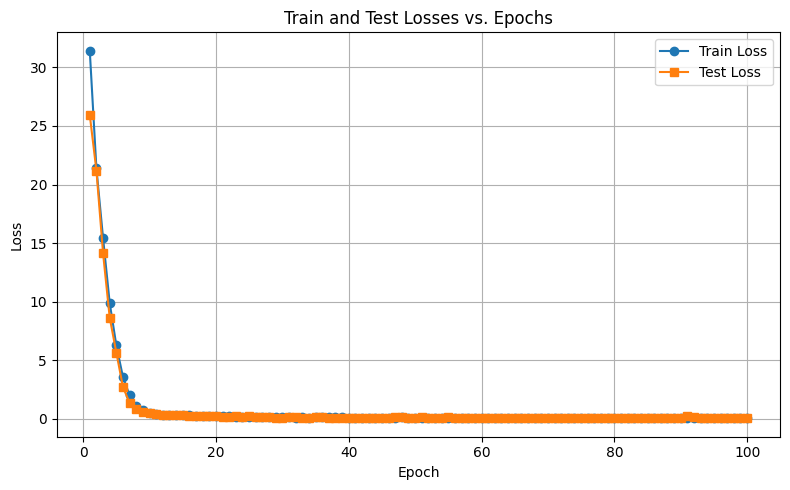

In [15]:
epochs = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, test_losses, marker='s', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Losses vs. Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(
    os.path.join(figures_dir, "train_and_test_losses_vs_epochs.pdf"),
    bbox_inches="tight"
)
plt.show()

In [16]:
# Extract the saved samples
times, original_animation, human_input, reconstructed_animation = test_samples[0]["times"], test_samples[0][
    "original_animation"], test_samples[0]["human_input"], test_samples[0]["reconstructed_animation"]

print(times.shape, original_animation.shape, human_input.shape, reconstructed_animation.shape)

torch.Size([150, 1]) torch.Size([150, 2]) torch.Size([150, 2]) torch.Size([150, 2])


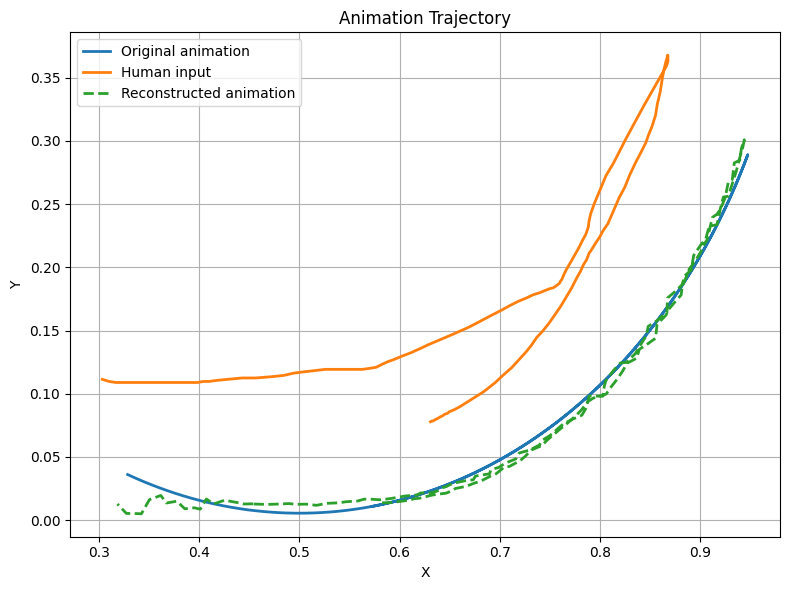

In [17]:
# Plot X, Y for animation trajectories
plt.figure(figsize=(8, 6))
plt.plot(original_animation[:, 0], original_animation[:, 1], label="Original animation", linewidth=2)
plt.plot(human_input[:, 0], human_input[:, 1], label="Human input", linewidth=2)
plt.plot(reconstructed_animation[:, 0], reconstructed_animation[:, 1], label="Reconstructed animation", linewidth=2,
         linestyle='--')

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Animation Trajectory")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(
    os.path.join(figures_dir, "animation_trajectory.pdf"),
    bbox_inches="tight"  # ensures everything fits in the figure
)

In [18]:
# Now predict for a brand-new movement path
BATCH_SIZE = 1
with torch.no_grad():
    which_sample = test_dataset[0]
    z = torch.randn(1, Z_DIM).to(device)
    c = which_sample["human_input"]
    c = c.reshape(BATCH_SIZE, SAMPLE_LENGTH, NUM_DIMS)
    c = c.to(device)
    times = which_sample["times"]
    
    sample = cvae.decoder(z, c)
    sample = sample.reshape(BATCH_SIZE, SAMPLE_LENGTH, NUM_DIMS)

z shape: torch.Size([1, 10]), c shape: torch.Size([1, 150, 2])


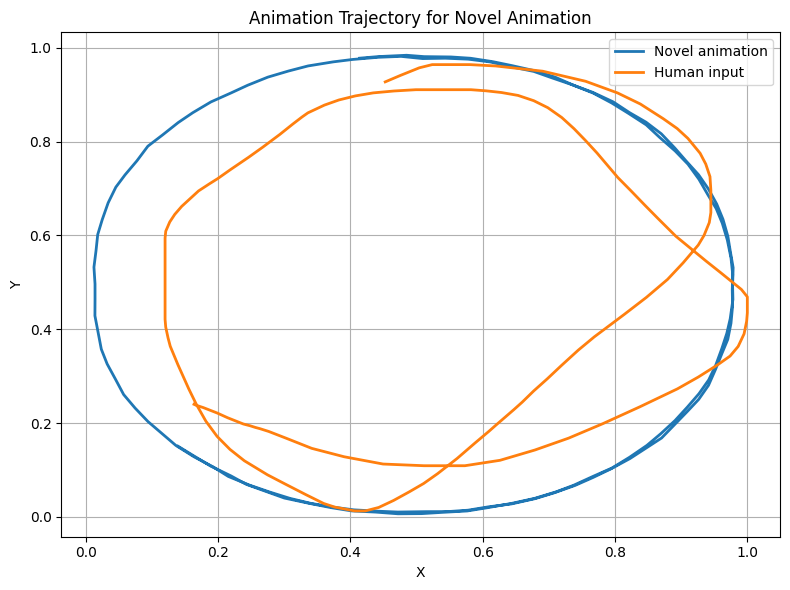

In [19]:
# Plot X, Y for animation trajectories
plt.figure(figsize=(8, 6))
plt.plot(sample[0, :, 0], sample[0, :, 1], label="Novel animation", linewidth=2)
plt.plot(c[0, :, 0], c[0, :, 1], label="Human input", linewidth=2)

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Animation Trajectory for Novel Animation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(
    os.path.join(figures_dir, "animation_trajectory_novel.pdf"),
    bbox_inches="tight"  # ensures everything fits in the figure
)

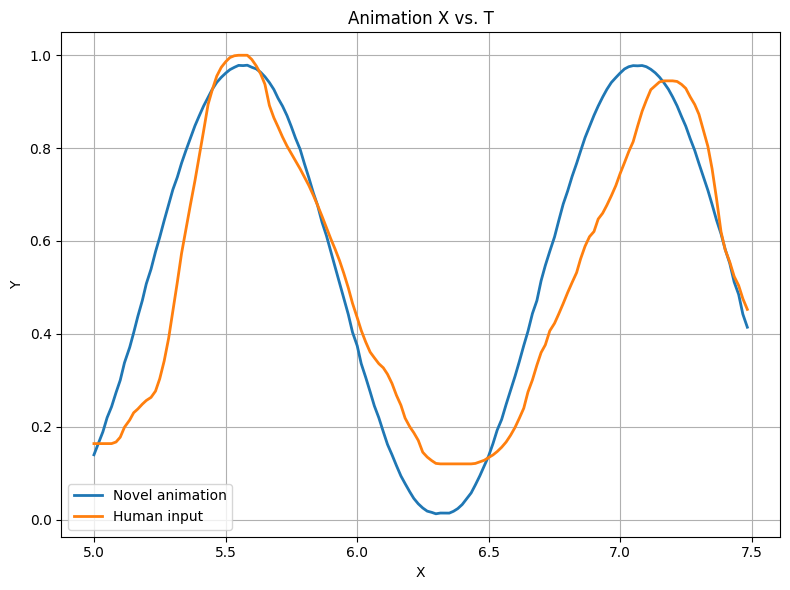

In [20]:
# Plot T, X for animation trajectories
plt.figure(figsize=(8, 6))
plt.plot(times[:, 0], sample[0, :, 0], label="Novel animation", linewidth=2)
plt.plot(times[:, 0], c[0, :, 0], label="Human input", linewidth=2)

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Animation X vs. T")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(
    os.path.join(figures_dir, "animation_novel_x_vs_t.pdf"),
    bbox_inches="tight"  # ensures everything fits in the figure
)